In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<img width="500" style="float:center" 
     src="GroupC.png" />

# GROUP C 
## Analysis of PVPC - market signals for home battery storage


# Sections
* [Description - Analysis of PVPC](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Processing of Raw Data: data curation](#2)
  * [2.1 Spark data abstraction (DataFrame) for the json files](#2.1)
  * [2.2 Create a new DataFrame containing needed information](#2.2)
  * [2.3 Separate the DataFrame into two](#2.3)  
  * [2.4 DataFrames combination (join) to enrich data](#2.4)
* [3.Data set meta analysis](#3) 
* [4.Columns groups basic profiling to better understand our data set](#4) 
* [5.Answers to business questions](#5)
  * [5.1 New features for analysis: Daily Max, Min, Avg and Spread](#5.1)
  * [5.2 Hourly prices behaviour analysis](#5.2)
  * [5.3 Ratio of Daily Spreads](#5.3)
  * [5.4 Top 5 Top Days in extrem Spread](#5.4)

<a id='0'></a>
# Description of the PVPC tariff

PVPC is a regulated tariff for households. This tariff is calculated adding several costs to the wholesale spot (hourly) prices and hence it is a variable tariff. However these added costs are variable as well, and hence, the daily pattern of PVPC prices is not exactly the same than the SPOT prices. 

In the current context of volatile electricity prices, we are interested in obtaining hourly prices of electricity and studying the daily spread (max price-min price of the day) for a household with the regulated tariff in Spain. The evolution of this spread is a key parameter for the analysis of profitability of investing in distributed electricity storage.  

We finalize the analysis with the calculation of a ratio of days in order to categorize the different spreads for both PVPC and SPOT prices in different intervals.   

The regulated households tariff (voluntary price for the small consumers) is called PVPC and is linked to the wholesale market price and published by REE (Spanish Transport System Operator)

SOURCE OF DATA : API from REE (Spanish Transport System Operator) called APIDATOS (https://www.ree.es/es/apidatos)

<a id='1'></a>
# 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
## 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
## 1.2 Search for Spark Installation 

In [2]:
import findspark
findspark.init()

Pandas setup to display contents in a better way:

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
## 1.3 Create SparkSession
Give the Spark job a name and check the Spark version you're running to be sure that all the functions you'll use will be available and will behave as you expect.

In [4]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder\
                    .appName("Spain's Electricity Consumer Regulated Price")\
                    .getOrCreate()

print(f"This cluster relies on Spark '{spark.version}'")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


This cluster relies on Spark '3.2.1'


<a id='2'></a>
# 2. Processing of Raw Data: data curation 

<a id='2.1'></a>
## 2.1 Spark data abstraction (DataFrame) for JSON
We are reading from the json files and checking the schema from the json files. 

In [5]:
from  pyspark.sql.functions import input_file_name

# DataFrame creation
pvpcDF = spark.read.json("hdfs://localhost:9000/datalake/raw/REE/2022/*/*/*")

# DataFrame updated with an additional column containing the filename contributing to the data in every row.
pvpcDF = pvpcDF.withColumn("filename_path", input_file_name())

# The inferred schema can be visualized using the printSchema() method - definitely semi-structured data.
pvpcDF.printSchema()

root
 |-- attributes: struct (nullable = true)
 |    |-- color: string (nullable = true)
 |    |-- composite: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- last-update: string (nullable = true)
 |    |-- magnitude: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- datetime: string (nullable = true)
 |    |    |    |-- percentage: double (nullable = true)
 |    |    |    |-- value: double (nullable = true)
 |-- groupId: string (nullable = true)
 |-- id: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- cache-control: struct (nullable = true)
 |    |    |-- cache: string (nullable = true)
 |-- type: string (nullable = true)
 |-- filename_path: string (nullable = false)



In [6]:
from  pyspark.sql.functions import col

pvpcDF.select("filename_path")\
                      .distinct()\
                      .orderBy(col("filename_path").desc())\
                      .limit(10)\
                      .toPandas()

,filename_path
0,hdfs://localhost:9000/datalake/raw/REE/2022/06/9/2022-06-9.json
1,hdfs://localhost:9000/datalake/raw/REE/2022/06/8/2022-06-8.json
2,hdfs://localhost:9000/datalake/raw/REE/2022/06/7/2022-06-7.json
3,hdfs://localhost:9000/datalake/raw/REE/2022/06/6/2022-06-6.json
4,hdfs://localhost:9000/datalake/raw/REE/2022/06/5/2022-06-5.json
5,hdfs://localhost:9000/datalake/raw/REE/2022/06/4/2022-06-4.json
6,hdfs://localhost:9000/datalake/raw/REE/2022/06/30/2022-06-30.json
7,hdfs://localhost:9000/datalake/raw/REE/2022/06/3/2022-06-3.json
8,hdfs://localhost:9000/datalake/raw/REE/2022/06/29/2022-06-29.json
9,hdfs://localhost:9000/datalake/raw/REE/2022/06/28/2022-06-28.json


Let's retrieve ***the first row to have a good sense of the data*** we're going to work with; let's calculate ***how many rows there are*** in the DataFrame as well:

In [7]:
pvpcDF.limit(3).select("attributes").show(3,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
print(f"This DataFrame has {pvpcDF.count()}")

This DataFrame has 633


We see above that there are 3 rows of different data: the header, the PVPC (24 values) and the spot market price (24 values)

In [9]:
#The data we are interested in: "datetime" and "value" is contained in the array "values" and this one is nested inside the column "attributes"
pvpcDF.select("attributes.values")\
                      .distinct()\
                      .orderBy(col("attributes.values").desc())\
                      .limit(2)\
                      .toPandas()

,values
0,"[(2022-06-30T00:00:00.000+02:00, 0.6643621121603392, 275.79), (2022-06-30T01:00:00.000+02:00, 0.6703516377649326, 278.33), (2022-06-30T02:00:00.000+02:00, 0.6768656892603347, 286.7), (2022-06-30T03:00:00.000+02:00, 0.67767929089444, 294.35), (2022-06-30T04:00:00.000+02:00, 0.6775311908400429, 297.05), (2022-06-30T05:00:00.000+02:00, 0.6730153612307409, 292.23), (2022-06-30T06:00:00.000+02:00, 0.671468284053576, 292.27), (2022-06-30T07:00:00.000+02:00, 0.6552747528708079, 287.03), (2022-06-30T08:00:00.000+02:00, 0.6728886448897429, 294.16), (2022-06-30T09:00:00.000+02:00, 0.6665936633085122, 273.93), (2022-06-30T10:00:00.000+02:00, 0.6949001227541569, 311.35), (2022-06-30T11:00:00.000+02:00, 0.6952547919588593, 297.43), (2022-06-30T12:00:00.000+02:00, 0.6957844311377246, 290.49), (2022-06-30T13:00:00.000+02:00, 0.6978972253328356, 280.45), (2022-06-30T14:00:00.000+02:00, 0.6612347409613925, 226.42), (2022-06-30T15:00:00.000+02:00, 0.6689217505837275, 223.46), (2022-06-30T16:00:00.000+02:00, 0.6799579269458788, 213.33), (2022-06-30T17:00:00.000+02:00, 0.682057164707007, 214.05), (2022-06-30T18:00:00.000+02:00, 0.7272502676439101, 264.93), (2022-06-30T19:00:00.000+02:00, 0.7161453177588597, 289.38), (2022-06-30T20:00:00.000+02:00, 0.7054026718361498, 334.77), (2022-06-30T21:00:00.000+02:00, 0.6958590033533494, 356.92), (2022-06-30T22:00:00.000+02:00, 0.6650899569220373, 314.96), (2022-06-30T23:00:00.000+02:00, 0.6786357014311424, 316.76)]"
1,"[(2022-06-30T00:00:00.000+02:00, 0.33563788783966086, 139.33), (2022-06-30T01:00:00.000+02:00, 0.32964836223506744, 136.87), (2022-06-30T02:00:00.000+02:00, 0.32313431073966525, 136.87), (2022-06-30T03:00:00.000+02:00, 0.32232070910556, 140.0), (2022-06-30T04:00:00.000+02:00, 0.3224688091599571, 141.38), (2022-06-30T05:00:00.000+02:00, 0.32698463876925904, 141.98), (2022-06-30T06:00:00.000+02:00, 0.32853171594642405, 143.0), (2022-06-30T07:00:00.000+02:00, 0.34472524712919206, 151.0), (2022-06-30T08:00:00.000+02:00, 0.3271113551102571, 143.0), (2022-06-30T09:00:00.000+02:00, 0.3334063366914878, 137.01), (2022-06-30T10:00:00.000+02:00, 0.3050998772458431, 136.7), (2022-06-30T11:00:00.000+02:00, 0.30474520804114075, 130.37), (2022-06-30T12:00:00.000+02:00, 0.30421556886227547, 127.01), (2022-06-30T13:00:00.000+02:00, 0.30210277466716434, 121.4), (2022-06-30T14:00:00.000+02:00, 0.3387652590386076, 116.0), (2022-06-30T15:00:00.000+02:00, 0.3310782494162725, 110.6), (2022-06-30T16:00:00.000+02:00, 0.32004207305412125, 100.41), (2022-06-30T17:00:00.000+02:00, 0.317942835292993, 99.78), (2022-06-30T18:00:00.000+02:00, 0.2727497323560899, 99.36), (2022-06-30T19:00:00.000+02:00, 0.2838546822411404, 114.7), (2022-06-30T20:00:00.000+02:00, 0.29459732816385015, 139.81), (2022-06-30T21:00:00.000+02:00, 0.3041409966466505, 156.0), (2022-06-30T22:00:00.000+02:00, 0.3349100430779627, 158.6), (2022-06-30T23:00:00.000+02:00, 0.3213642985688577, 150.0)]"


We generate the following transformations: create a new column "additional", explode the content of the nested array "values" and store the data in the new column

In [10]:
from  pyspark.sql.functions import explode, min, max, avg


pvpcDF.withColumn("additional", explode("attributes.values")).printSchema()

root
 |-- attributes: struct (nullable = true)
 |    |-- color: string (nullable = true)
 |    |-- composite: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- last-update: string (nullable = true)
 |    |-- magnitude: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- values: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- datetime: string (nullable = true)
 |    |    |    |-- percentage: double (nullable = true)
 |    |    |    |-- value: double (nullable = true)
 |-- groupId: string (nullable = true)
 |-- id: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- cache-control: struct (nullable = true)
 |    |    |-- cache: string (nullable = true)
 |-- type: string (nullable = true)
 |-- filename_path: string (nullable = false)
 |-- additional: struct (nullable = true)
 |    |-- datetime: string (nullable = true)
 |   

In [11]:
#let's explore in more detail the data:
number_of_elements = pvpcDF.limit(1)\
                            .withColumn("additional", explode("attributes.values"))\
                            .count()
print(f"Starting with 1 row and ending up with {number_of_elements} rows.")

Starting with 1 row and ending up with 0 rows.


<a id='2.2'></a>
# 2.2 Create a  new DataFrame containing needed information
Now we are going to create a new DF with the information we need

In [12]:
pvpcvaluesDF = pvpcDF.withColumn("additional", explode("attributes.values"))\
                                            .select("additional.datetime", "additional.value", "type")
pvpcvaluesDF.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- value: double (nullable = true)
 |-- type: string (nullable = true)



In [13]:
print("Number of rows=",pvpcvaluesDF.count())
pvpcvaluesDF.limit(4).show()
pvpcvaluesDF.limit(35).toPandas()


Number of rows= 10126
+--------------------+------+------------+
|            datetime| value|        type|
+--------------------+------+------------+
|2022-04-15T00:00:...|274.52|PVPC (€/MWh)|
|2022-04-15T01:00:...|265.48|PVPC (€/MWh)|
|2022-04-15T02:00:...|262.97|PVPC (€/MWh)|
|2022-04-15T03:00:...|260.87|PVPC (€/MWh)|
+--------------------+------+------------+



,datetime,value,type
0,2022-04-15T00:00:00.000+02:00,274.52,PVPC (€/MWh)
1,2022-04-15T01:00:00.000+02:00,265.48,PVPC (€/MWh)
2,2022-04-15T02:00:00.000+02:00,262.97,PVPC (€/MWh)
3,2022-04-15T03:00:00.000+02:00,260.87,PVPC (€/MWh)
4,2022-04-15T04:00:00.000+02:00,259.76,PVPC (€/MWh)
5,2022-04-15T05:00:00.000+02:00,265.41,PVPC (€/MWh)
6,2022-04-15T06:00:00.000+02:00,272.52,PVPC (€/MWh)
7,2022-04-15T07:00:00.000+02:00,288.36,PVPC (€/MWh)
8,2022-04-15T08:00:00.000+02:00,329.67,PVPC (€/MWh)
9,2022-04-15T09:00:00.000+02:00,317.06,PVPC (€/MWh)


<a id='2.3'></a>
# 2.3 Separate the DataFrame into two 
We have seen that PVPC and SPOT prices are shown in different rows for each hour. Previously to combine them in a single row, we are going to separate the DF in 2, one with PVPCs and another with Spot market price

In [14]:
#Now with the PVPC price
pvpc_onlyDF = pvpcvaluesDF.where("type='PVPC (€/MWh)'").orderBy(col("datetime").asc())
pvpc_onlyDF.limit(40).toPandas()                                                            

,datetime,value,type
0,2022-01-01T00:00:00.000+01:00,204.51,PVPC (€/MWh)
1,2022-01-01T01:00:00.000+01:00,171.35,PVPC (€/MWh)
2,2022-01-01T02:00:00.000+01:00,172.70,PVPC (€/MWh)
3,2022-01-01T03:00:00.000+01:00,156.07,PVPC (€/MWh)
4,2022-01-01T04:00:00.000+01:00,159.08,PVPC (€/MWh)
5,2022-01-01T05:00:00.000+01:00,157.28,PVPC (€/MWh)
6,2022-01-01T06:00:00.000+01:00,158.87,PVPC (€/MWh)
7,2022-01-01T07:00:00.000+01:00,157.58,PVPC (€/MWh)
8,2022-01-01T08:00:00.000+01:00,156.18,PVPC (€/MWh)
9,2022-01-01T09:00:00.000+01:00,118.96,PVPC (€/MWh)


In [15]:
#Now the spot price
spot_onlyDF = pvpcvaluesDF.where("type='Precio mercado spot (€/MWh)'").orderBy(col("datetime").asc())
spot_onlyDF.limit(40).toPandas() 

,datetime,value,type
0,2022-01-01T00:00:00.000+01:00,145.86,Precio mercado spot (€/MWh)
1,2022-01-01T01:00:00.000+01:00,114.90,Precio mercado spot (€/MWh)
2,2022-01-01T02:00:00.000+01:00,113.87,Precio mercado spot (€/MWh)
3,2022-01-01T03:00:00.000+01:00,97.80,Precio mercado spot (€/MWh)
4,2022-01-01T04:00:00.000+01:00,97.80,Precio mercado spot (€/MWh)
5,2022-01-01T05:00:00.000+01:00,95.74,Precio mercado spot (€/MWh)
6,2022-01-01T06:00:00.000+01:00,97.80,Precio mercado spot (€/MWh)
7,2022-01-01T07:00:00.000+01:00,97.80,Precio mercado spot (€/MWh)
8,2022-01-01T08:00:00.000+01:00,97.80,Precio mercado spot (€/MWh)
9,2022-01-01T09:00:00.000+01:00,70.05,Precio mercado spot (€/MWh)


Count the number of rows

In [16]:
pvpc_onlyDF.count()

5063

In [17]:
spot_onlyDF.count()

5063

Show the type of the Dataframe

In [18]:
type(spot_onlyDF)

pyspark.sql.dataframe.DataFrame

Rename the columns of the Spot prices 

In [19]:
spot=spot_onlyDF.withColumn("SPOT", col("value")).select("datetime", "SPOT")

In [20]:
spot.limit(4).show()

+--------------------+------+
|            datetime|  SPOT|
+--------------------+------+
|2022-01-01T00:00:...|145.86|
|2022-01-01T01:00:...| 114.9|
|2022-01-01T02:00:...|113.87|
|2022-01-01T03:00:...|  97.8|
+--------------------+------+



Drop duplicates of the spot table 

In [21]:
spot = spot.dropDuplicates()

In [22]:
spot.limit(4).show()

+--------------------+------+
|            datetime|  SPOT|
+--------------------+------+
|2022-04-15T11:00:...|170.91|
|2022-04-23T09:00:...| 72.02|
|2022-04-08T11:00:...| 145.1|
|2022-04-26T01:00:...|231.13|
+--------------------+------+



We will use to_date() function to convert TimestampType column to DateType column and create a new dataframe called "pricesDF" with the data needed from the PVPC table. In further step we will add the SPOT prices column 

In [23]:
from pyspark.sql.functions import to_date
from pyspark.sql.functions import hour
from pyspark.sql.functions import month
from pyspark.sql.functions import date_format
from pyspark.sql.functions import dayofweek
pricesDF = pvpc_onlyDF.withColumn("date",to_date(col("datetime")))\
        .withColumn("month",month(col("datetime")))\
        .withColumn("hour",hour(col("datetime")))\
        .withColumn("day",date_format("datetime", 'EEEE'))\
        .withColumn('day_of_week',dayofweek(col("datetime")))\
        .withColumn("PVPC",col("value"))\
        .select("datetime", "date", "month","day","day_of_week","hour", "PVPC")

In [24]:
type(pricesDF)

pyspark.sql.dataframe.DataFrame

In [25]:
pricesDF.limit(5).show()

+--------------------+----------+-----+--------+-----------+----+------+
|            datetime|      date|month|     day|day_of_week|hour|  PVPC|
+--------------------+----------+-----+--------+-----------+----+------+
|2022-01-01T00:00:...|2022-01-01|    1|Saturday|          7|   0|204.51|
|2022-01-01T01:00:...|2022-01-01|    1|Saturday|          7|   1|171.35|
|2022-01-01T02:00:...|2022-01-01|    1|Saturday|          7|   2| 172.7|
|2022-01-01T03:00:...|2022-01-01|    1|Saturday|          7|   3|156.07|
|2022-01-01T04:00:...|2022-01-01|    1|Saturday|          7|   4|159.08|
+--------------------+----------+-----+--------+-----------+----+------+



We haven't identified duplicates but just in case we drop duplicates of the pricesDF table 

In [26]:
pricesDF= pricesDF.dropDuplicates()

In [27]:
pricesDF.limit(4).show()

+--------------------+----------+-----+---------+-----------+----+------+
|            datetime|      date|month|      day|day_of_week|hour|  PVPC|
+--------------------+----------+-----+---------+-----------+----+------+
|2022-04-25T00:00:...|2022-04-25|    4|   Monday|          2|   0|330.01|
|2022-04-27T11:00:...|2022-04-27|    4|Wednesday|          4|  11|335.39|
|2022-04-05T00:00:...|2022-04-05|    4|  Tuesday|          3|   0|306.14|
|2022-04-10T20:00:...|2022-04-10|    4|   Sunday|          1|  20|286.65|
+--------------------+----------+-----+---------+-----------+----+------+



<a id='2.4'></a>
# 2.4 Join the two Dataframes 

Now, we join the DF with the SPOT prices to the one we have just created "pricesDF" and store it as "prices", our final Data Frame

In [28]:
prices=pricesDF.join(spot,pricesDF.datetime == spot.datetime,"inner")\
        .select("date", "hour","month","day","day_of_week", "PVPC", "SPOT")

In [53]:
print('Final DataFrame')
prices.limit(4).show()

Final DataFrame
+----------+----+-----+---------+-----------+------+------+
|      date|hour|month|      day|day_of_week|  PVPC|  SPOT|
+----------+----+-----+---------+-----------+------+------+
|2022-04-25|   0|    4|   Monday|          2|330.01|267.43|
|2022-04-27|  11|    4|Wednesday|          4|335.39|216.74|
|2022-04-05|   0|    4|  Tuesday|          3|306.14| 245.0|
|2022-04-10|  20|    4|   Sunday|          1|286.65|227.91|
+----------+----+-----+---------+-----------+------+------+



<a id='3'></a>
## 3. Data set metadata analysis
### Display final schema and size of the DataFrame

In [30]:
from IPython.display import display, Markdown
prices.printSchema()
display(Markdown("This DataFrame has **%d rows**." % prices.count()))

root
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- PVPC: double (nullable = true)
 |-- SPOT: double (nullable = true)



This DataFrame has **4343 rows**.

In [31]:
type(prices)

pyspark.sql.dataframe.DataFrame

### Checking for NULL and NA values 

In [32]:
from pyspark.sql.functions import isnan, when, count
prices.select([count(when(isnan(col(c)), c)).alias(c) for c in["PVPC", "SPOT"]]).show()

+----+----+
|PVPC|SPOT|
+----+----+
|   0|   0|
+----+----+



### Checking for Distinct values 

In [33]:
from pyspark.sql.functions import countDistinct
print("Checking amount of distinct values in columns Year, Month, DayofMonth and DayOfWeek:")
prices.select([countDistinct(c).alias(c) for c in [ "hour","month","day","day_of_week"]]).show()

Checking amount of distinct values in columns Year, Month, DayofMonth and DayOfWeek:


+----+-----+---+-----------+
|hour|month|day|day_of_week|
+----+-----+---+-----------+
|  24|    6|  7|          7|
+----+-----+---+-----------+



<a id='4'></a>
## 4. Columns groups basic profiling to better understand our data set

In [34]:
prices.summary().show()

+-------+-----------------+------------------+---------+-----------------+------------------+------------------+
|summary|             hour|             month|      day|      day_of_week|              PVPC|              SPOT|
+-------+-----------------+------------------+---------+-----------------+------------------+------------------+
|  count|             4343|              4343|     4343|             4343|              4343|              4343|
|   mean|11.50218742804513|3.5084043288049735|     null|3.989638498733594|296.89882109141115|205.94700667741236|
| stddev|6.922279087878654|1.7103367455121121|     null|1.999915574706061| 90.28259492644317| 67.66606348942214|
|    min|                0|                 1|   Friday|                1|             25.19|              1.03|
|    25%|                6|                 2|     null|                2|            244.39|            170.57|
|    50%|               12|                 4|     null|                4|            286.32|   

2022-S1 PVPC and SPOT prices


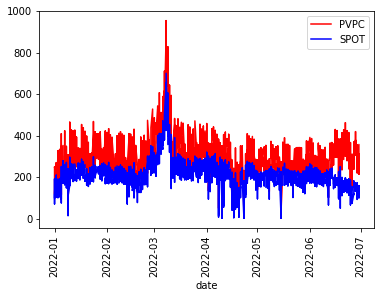

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
print('2022-S1 PVPC and SPOT prices')
pdf = (
    prices.select(
        "date",
        "PVPC"
    )
    .orderBy("day")
    .toPandas()
)
pdf2 = (
    prices.select(
        "date",
        "SPOT"
    )
    .orderBy("date")
    .toPandas()
)
ax = pdf.plot(x='date', y='PVPC', color='red')
pdf2.plot(ax=ax, x='date', y='SPOT', color='blue')
plt.xticks(rotation=90)
plt.show()

<a id='5'></a>
## 5.Answers to business questions
<a id='5.1'></a>
### 5.1. New features for analysis: Daily Max, Min, Avg and Spread 
In order to perform the business questions analysis, we obtain and add columns with Max, Min and Spread for each day

In [36]:
daily_prices=prices.groupBy("date").agg(avg('PVPC').alias('PVPC_AVG'), 
                                        max("PVPC").alias('PVPC_MAX'),
                                        min("PVPC").alias('PVPC_MIN'), 
                                        (max("PVPC")-min("PVPC")).alias("PVPC_spread"),\
                                        avg('SPOT').alias('SPOT_AVG'),
                                        max("SPOT").alias('SPOT_MAX'), 
                                        min("SPOT").alias('SPOT_MIN'), 
                                        (max("SPOT")-min("SPOT")).alias("SPOT_spread")).orderBy("date")

In [37]:
daily_prices.limit(10).show()

+----------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+
|      date|          PVPC_AVG|PVPC_MAX|PVPC_MIN|       PVPC_spread|          SPOT_AVG|SPOT_MAX|SPOT_MIN|       SPOT_spread|
+----------+------------------+--------+--------+------------------+------------------+--------+--------+------------------+
|2022-01-01|178.27291666666665|  248.88|  118.96|129.92000000000002|122.62916666666668|  190.81|   70.05|            120.76|
|2022-01-02|187.08333333333334|  268.11|  141.13|126.98000000000002| 136.9683333333333|   209.1|   103.7|105.39999999999999|
|2022-01-03|         236.62625|  326.48|  164.71|            161.77| 150.4983333333333|  189.26|  100.36| 88.89999999999999|
|2022-01-04|239.99208333333334|  332.83|  152.68|180.14999999999998| 152.1454166666667|   190.0|   105.0|              85.0|
|2022-01-05|272.31749999999994|  408.58|  114.73|293.84999999999997|180.20000000000002|  250.34|   75.38|            174.96|


In [38]:
daily_prices.toPandas()

,date,PVPC_AVG,PVPC_MAX,PVPC_MIN,PVPC_spread,SPOT_AVG,SPOT_MAX,SPOT_MIN,SPOT_spread
0,2022-01-01,178.272917,248.88,118.96,129.92,122.629167,190.81,70.05,120.76
1,2022-01-02,187.083333,268.11,141.13,126.98,136.968333,209.10,103.70,105.40
2,2022-01-03,236.626250,326.48,164.71,161.77,150.498333,189.26,100.36,88.90
3,2022-01-04,239.992083,332.83,152.68,180.15,152.145417,190.00,105.00,85.00
4,2022-01-05,272.317500,408.58,114.73,293.85,180.200000,250.34,75.38,174.96
...,...,...,...,...,...,...,...,...,...
176,2022-06-26,229.921667,310.77,143.11,167.66,117.942500,153.21,74.25,78.96
177,2022-06-27,280.699167,368.86,237.66,131.20,143.270000,181.00,115.25,65.75
178,2022-06-28,352.515833,418.89,304.93,113.96,144.664167,171.09,131.20,39.89
179,2022-06-29,306.202083,356.09,219.86,136.23,132.740000,172.28,92.07,80.21


Daily MAX and MIN PVPC Prices


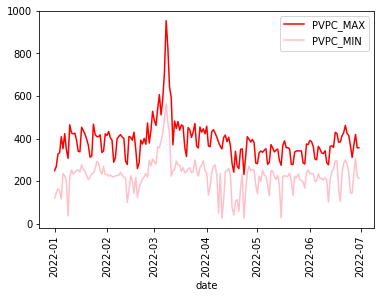

In [39]:
import pandas as pd
from matplotlib import pyplot as plt
print('Daily MAX and MIN PVPC Prices')
pdf = (
    daily_prices.select(
        "date",
        "PVPC_MAX"
    )
    .orderBy("date")
    .toPandas()
)
pdf2 = (
    daily_prices.select(
        "date",
        "PVPC_MIN"
    )
    .orderBy("date")
    .toPandas()
)
ax = pdf.plot(x='date', y='PVPC_MAX', color='red')
pdf2.plot(ax=ax, x='date', y='PVPC_MIN', color='pink')
plt.xticks(rotation=90)
plt.show()

Daily MAX and MIN SPOT Prices


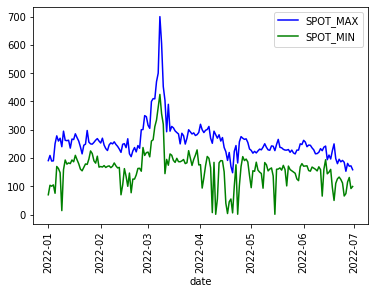

In [40]:
import pandas as pd
from matplotlib import pyplot as plt
print('Daily MAX and MIN SPOT Prices')
pdf = (
    daily_prices.select(
        "date",
        "SPOT_MAX"
    )
    .orderBy("date")
    .toPandas()
)
pdf2 = (
    daily_prices.select(
        "date",
        "SPOT_MIN"
    )
    .orderBy("date")
    .toPandas()
)
ax = pdf.plot(x='date', y='SPOT_MAX', color='blue')
pdf2.plot(ax=ax, x='date', y='SPOT_MIN', color='green')
plt.xticks(rotation=90)
plt.show()

Daily Spreads of SPOT and PVPC


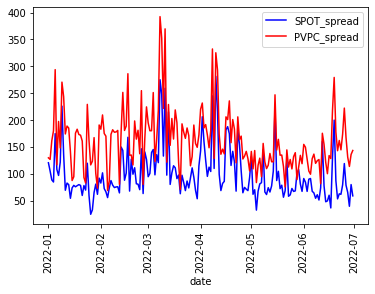

In [41]:
import pandas as pd
from matplotlib import pyplot as plt
print('Daily Spreads of SPOT and PVPC')
pdf = (
    daily_prices.select(
        "date",
        "SPOT_spread"
    )
    .orderBy("date")
    .toPandas()
)
pdf2 = (
    daily_prices.select(
        "date",
        "PVPC_spread"
    )
    .orderBy("date")
    .toPandas()
)
ax = pdf.plot(x='date', y='SPOT_spread', color='blue')
pdf2.plot(ax=ax, x='date', y='PVPC_spread', color='red')
plt.xticks(rotation=90)
plt.show()

<a id='5.2'></a>
### 5.2. Hourly prices behaviour analysis

In [42]:
hour_prices=prices.groupBy("hour").agg(avg('PVPC').alias('PVPC_AVG'), 
                                        max("PVPC").alias('PVPC_MAX'), 
                                        min("PVPC").alias('PVPC_MIN'), 
                                        (max("PVPC")-min("PVPC")).alias("PVPC_spread"),\
                                        avg('SPOT').alias('SPOT_AVG'),
                                        max("SPOT").alias('SPOT_MAX'), 
                                        min("SPOT").alias('SPOT_MIN'), 
                                        (max("SPOT")-min("SPOT")).alias("SPOT_spread")).orderBy("hour")

In [43]:
hour_prices.toPandas()

,hour,PVPC_AVG,PVPC_MAX,PVPC_MIN,PVPC_spread,SPOT_AVG,SPOT_MAX,SPOT_MIN,SPOT_spread
0,0,284.883315,641.16,151.22,489.94,215.219116,510.26,95.90,414.36
1,1,273.228564,577.89,139.61,438.28,201.307072,450.01,81.00,369.01
2,2,267.204389,588.29,122.50,465.79,193.454722,449.50,80.11,369.39
3,3,262.060166,561.63,100.83,460.80,187.483702,424.88,55.46,369.42
4,4,260.653923,567.05,90.10,476.95,185.832155,429.89,45.82,384.07
5,5,267.601768,579.88,94.50,485.38,192.627182,449.60,48.50,401.10
6,6,283.343204,696.85,123.58,573.27,209.213867,550.00,74.29,475.71
7,7,298.544586,744.25,140.44,603.81,226.412928,600.00,89.78,510.22
8,8,318.007072,816.67,127.26,689.41,228.956519,645.00,86.69,558.31
9,9,302.010773,755.51,106.91,648.60,220.461050,601.00,70.05,530.95


Spread of MAX and MIN Prices PVPC per Date


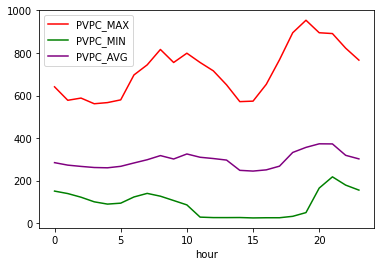

In [44]:
import pandas as pd
from matplotlib import pyplot as plt
print('Spread of MAX and MIN Prices PVPC per Date')
pdf = (
    hour_prices.select(
        "hour",
        "PVPC_MAX"
    )
    .orderBy("hour")
    .toPandas()
)
pdf2 = (
    hour_prices.select(
        "hour",
        "PVPC_MIN"
    )
    .orderBy("hour")
    .toPandas()
)
pdf3 = (
    hour_prices.select(
        "hour",
        "PVPC_AVG"
    )
    .orderBy("hour")
    .toPandas()
)
ax = pdf.plot(x='hour', y='PVPC_MAX', color='red')
pdf2.plot(ax=ax, x='hour', y='PVPC_MIN', color='green')
pdf3.plot(ax=ax, x='hour', y='PVPC_AVG', color='purple')
plt.show()

<a id='5.3'></a>
### 5.3. Ratio of Daily Spreads 
Ratio of the Spread by severity by the SPOT Spread

In [45]:
from pyspark.sql.functions import count, round

# Threshold is categorized as follows:
#
#   "Low"      - Difference of Spot spread is low <50
#   "Medium"   - Medium Spot Spread (50,100)
#   "High"     - High SPOT Spread (100,200)
#   "Extrem High"     - Extrem High SPOT Spread (200,500)

# 1. Let's enrich the DF spread severity based on our categorization
total = daily_prices.count()
Threshold_SPOT = daily_prices\
   .where(col("SPOT_spread")!=0)\
   .withColumn("SPOT_Ratio", when(col("SPOT_spread")<=50,"1.Low")
                               .when((col("SPOT_spread")>50) & (col("SPOT_spread")<=100),"2.Medium")\
                               .when((col("SPOT_spread")>100) & (col("SPOT_spread")<=200),"3.High")\
                               .otherwise("4.Extrem High"))\
    .cache() # optimization to make the processing faster

# 2. Ready to answer to this business question
Threshold_SPOT.select("SPOT_Ratio", "SPOT_spread")\
                     .groupBy("SPOT_Ratio")\
                     .agg(count("SPOT_Ratio").alias("Num"), \
                          (count("SPOT_Ratio")/total*100).alias("Ratio"))\
                     .orderBy("SPOT_Ratio")\
                     .select("SPOT_Ratio","Num",round("Ratio",1).alias("%")).show()

+-------------+---+----+
|   SPOT_Ratio|Num|   %|
+-------------+---+----+
|        1.Low|  7| 3.9|
|     2.Medium|110|60.8|
|       3.High| 54|29.8|
|4.Extrem High| 10| 5.5|
+-------------+---+----+



Ratio of the Spread by severity by the PVPC_spread

In [46]:
from pyspark.sql.functions import count, round

# Threshold is categorized as follows:
#
#   "Low"      - Difference of Spot spread is low <50
#   "Medium"   - Medium Spot Spread (50,100)
#   "High"     - High SPOT Spread (100,200)
#   "Extrem High"     - Extrem High SPOT Spread (200,500)

# 1. Let's enrich the DF spread severity based on our categorization
total = daily_prices.count()
Threshold_SPOT = daily_prices\
   .where(col("PVPC_spread")!=0)\
   .withColumn("PVPC_Ratio", when(col("PVPC_spread")<=50,"1.Low")
                               .when((col("PVPC_spread")>50) & (col("PVPC_spread")<=100),"2.Medium")\
                               .when((col("PVPC_spread")>100) & (col("PVPC_spread")<=200),"3.High")\
                               .otherwise("4.Extrem High"))\
    .cache() # optimization to make the processing faster

# 2. Ready to answer to this business question
Threshold_SPOT.select("PVPC_Ratio", "PVPC_spread")\
                     .groupBy("PVPC_Ratio")\
                     .agg(count("PVPC_Ratio").alias("Num"), \
                          (count("PVPC_Ratio")/total*100).alias("Ratio"))\
                     .orderBy("PVPC_Ratio")\
                     .select("PVPC_Ratio","Num",round("Ratio",1).alias("%")).show()

+-------------+---+----+
|   PVPC_Ratio|Num|   %|
+-------------+---+----+
|     2.Medium| 16| 8.8|
|       3.High|133|73.5|
|4.Extrem High| 32|17.7|
+-------------+---+----+



<a id='5.4'></a>
### 5.4. Top 5 Top Days in extrem Spread

For the Spot price

In [47]:
# Import Libraries
from pyspark.sql.functions import col

# Get top n records as Row Objects
row_list = daily_prices.orderBy(col("SPOT_spread").desc()).head(5)

# Convert row objects to DF
sorted_daily_prices = spark.createDataFrame(row_list)

# Display DataFrame
sorted_daily_prices.show()

+----------+-----------------+--------+--------+------------------+------------------+--------+--------+------------------+
|      date|         PVPC_AVG|PVPC_MAX|PVPC_MIN|       PVPC_spread|          SPOT_AVG|SPOT_MAX|SPOT_MIN|       SPOT_spread|
+----------+-----------------+--------+--------+------------------+------------------+--------+--------+------------------+
|2022-04-10|214.0070833333333|  351.01|   25.79|325.21999999999997|159.33124999999998|  282.48|    1.03|281.45000000000005|
|2022-03-08|715.3295833333333|  954.01|  561.63|            392.38|         544.98375|   700.0|  424.88|            275.12|
|2022-03-11|        402.89625|  593.09|  223.48|            369.61|         284.57875|  403.97|   144.8|            259.17|
|2022-03-09|628.0179166666667|  827.93|  475.48|352.44999999999993| 472.9704166666667|   605.0|  356.74|            248.26|
|2022-04-08|        234.38875|  382.35|   50.08|332.27000000000004|         154.69625|  252.08|     7.0|            245.08|
+-------

For PVPC price

In [48]:
# Import Libraries
from pyspark.sql.functions import col

# Get top n records as Row Objects
row_list = daily_prices.orderBy(col("PVPC_spread").desc()).head(5)

# Convert row objects to DF
sorted_daily_prices = spark.createDataFrame(row_list)

# Display DataFrame
sorted_daily_prices.show()

+----------+-----------------+--------+--------+------------------+------------------+--------+--------+------------------+
|      date|         PVPC_AVG|PVPC_MAX|PVPC_MIN|       PVPC_spread|          SPOT_AVG|SPOT_MAX|SPOT_MIN|       SPOT_spread|
+----------+-----------------+--------+--------+------------------+------------------+--------+--------+------------------+
|2022-03-08|715.3295833333333|  954.01|  561.63|            392.38|         544.98375|   700.0|  424.88|            275.12|
|2022-03-11|        402.89625|  593.09|  223.48|            369.61|         284.57875|  403.97|   144.8|            259.17|
|2022-03-09|628.0179166666667|  827.93|  475.48|352.44999999999993| 472.9704166666667|   605.0|  356.74|            248.26|
|2022-04-08|        234.38875|  382.35|   50.08|332.27000000000004|         154.69625|  252.08|     7.0|            245.08|
|2022-04-10|214.0070833333333|  351.01|   25.79|325.21999999999997|159.33124999999998|  282.48|    1.03|281.45000000000005|
+-------